### Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

### Load in Data 

In [2]:
df = pd.read_csv("engineered_stock_data.csv")

### Pick Features and Target

In [3]:
features = ["Close", "High", "Low", "Open", "Volume", 
            "RSI", "PROC", "SO", "WR", "OBV", "EWMA", "Close_detrend"]
targets = {"1-Day": "Target(1)", "30-Day": "Target(30)"}
seq_len = 30  

### Encode Stock Symbols

In [4]:
stock2id = {s: i for i, s in enumerate(df["Symbol"].unique())}
df["stock_id"] = df["Symbol"].map(stock2id)

### Normalize Features

In [5]:
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

### Build Sequences

For each stock:

- Take 30 days (seq_len) worth of features.

- Predict the target on the next day after those 30 days.

X = sequences of features

y = targets (up/down)

ids = stock IDs

In [6]:
def build_sequences(data, features, target_col, seq_len=30):
    X, y, ids = [], [], []
    for stock, stock_df in data.groupby("Symbol"):
        stock_df = stock_df.reset_index(drop=True)
        values = stock_df[features].values
        targets = stock_df[target_col].values
        stock_id = stock_df["stock_id"].iloc[0]

        for i in range(len(stock_df) - seq_len):
            X.append(values[i:i+seq_len])
            y.append(targets[i+seq_len])
            ids.append(stock_id)

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)
    ids = np.array(ids, dtype=np.int64)
    # 0 = down and 1 = up
    y = ((y + 1) // 2).astype(np.int64)
    return X, y, ids


### Dataset

In [7]:
class StockDataset(Dataset):
    def __init__(self, X, y, ids):
        self.X, self.y, self.ids = X, y, ids
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.ids[idx]


### LSTM Model and Stock Embedding

In [8]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, num_stocks, emb_dim=8, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(num_stocks, emb_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim + emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, stock_ids):
        emb = self.embedding(stock_ids)  # (batch, emb_dim)
        _, (hn, _) = self.lstm(x)
        hn = hn[-1]  # last hidden state
        combined = torch.cat([hn, emb], dim=1)
        return self.fc(combined)

### Train and Evaluate 

In [ ]:
def train_and_evaluate(X, y, ids, target_name):
    print(f"\n========== Training {target_name} Model ==========\n")

    # Train/test split
    X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
        X, y, ids, test_size=0.2, stratify=y, shuffle=True
    )

    # Convert to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    ids_train = torch.tensor(ids_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)
    ids_test = torch.tensor(ids_test, dtype=torch.long)

    # Class weights
    classes = np.unique(y_train.numpy())
    weights = compute_class_weight('balanced', classes=classes, y=y_train.numpy())
    weights = torch.tensor(weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=weights)

    # Dataset + loaders
    train_ds = StockDataset(X_train, y_train, ids_train)
    test_ds = StockDataset(X_test, y_test, ids_test)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64)

    # Model
    model = StockLSTM(
        input_dim=len(features), hidden_dim=128, num_layers=2,
        num_classes=2, num_stocks=len(stock2id), dropout=0.3
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Training loop
    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for xb, yb, idsb in train_loader:
            optimizer.zero_grad()
            out = model(xb, idsb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        print(f"[{target_name}] Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")
        
    # Evaluation
    model.eval()
    all_preds, all_probs, all_labels, all_stock_ids = [], [], [], []
    with torch.no_grad():
        for xb, yb, idsb in test_loader:
            out = model(xb, idsb)
            probs = torch.softmax(out, dim=1)[:, 1]  # prob of class 1
            preds = torch.argmax(out, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            all_stock_ids.extend(idsb.cpu().numpy())

    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_stock_ids = np.array(all_stock_ids)

    # Metrics
    accuracy = (all_preds == all_labels).mean()
    print(f"\n[{target_name}] Overall Test Accuracy: {accuracy:.2%}\n")
    print(classification_report(all_labels, all_preds, target_names=["Down", "Up"]))
    try:
        auc = roc_auc_score(all_labels, all_probs)
        print(f"[{target_name}] ROC-AUC: {auc:.4f}")
    except:
        print(f"[{target_name}] ROC-AUC could not be computed")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"{target_name} Confusion Matrix")
    plt.colorbar()
    plt.xticks([0, 1], ["Down", "Up"])
    plt.yticks([0, 1], ["Down", "Up"])
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='red', fontsize=16)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Per-stock accuracy
    id2stock = {v: k for k, v in stock2id.items()}
    stocks = np.unique(all_stock_ids)
    print(f"\n[{target_name}] Per-stock Test Accuracy:")
    for s in stocks:
        mask = all_stock_ids == s
        acc = (all_preds[mask] == all_labels[mask]).mean()
        print(f"{id2stock[s]:6s}: {acc:.2%}")

    # Probability Distribution
    plt.figure(figsize=(6, 4))
    plt.hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label="Down")
    plt.hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label="Up")
    plt.title(f"{target_name} Predicted Probabilities")
    plt.xlabel("Probability of Up")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

    return model

### Run both Target 1 and Target 30 Models


========== Training 1-Day Model ==========

[1-Day] Epoch 1, Loss: 0.6944
[1-Day] Epoch 2, Loss: 0.6939
[1-Day] Epoch 3, Loss: 0.6936
[1-Day] Epoch 4, Loss: 0.6943
[1-Day] Epoch 5, Loss: 0.6933
[1-Day] Epoch 6, Loss: 0.6921
[1-Day] Epoch 7, Loss: 0.6920
[1-Day] Epoch 8, Loss: 0.6911
[1-Day] Epoch 9, Loss: 0.6913
[1-Day] Epoch 10, Loss: 0.6905
[1-Day] Epoch 11, Loss: 0.6894
[1-Day] Epoch 12, Loss: 0.6878
[1-Day] Epoch 13, Loss: 0.6865
[1-Day] Epoch 14, Loss: 0.6837
[1-Day] Epoch 15, Loss: 0.6831
[1-Day] Epoch 16, Loss: 0.6811
[1-Day] Epoch 17, Loss: 0.6779
[1-Day] Epoch 18, Loss: 0.6766
[1-Day] Epoch 19, Loss: 0.6742
[1-Day] Epoch 20, Loss: 0.6691
[1-Day] Epoch 21, Loss: 0.6595
[1-Day] Epoch 22, Loss: 0.6572
[1-Day] Epoch 23, Loss: 0.6556
[1-Day] Epoch 24, Loss: 0.6489
[1-Day] Epoch 25, Loss: 0.6445
[1-Day] Epoch 26, Loss: 0.6420
[1-Day] Epoch 27, Loss: 0.6378
[1-Day] Epoch 28, Loss: 0.6394
[1-Day] Epoch 29, Loss: 0.6322
[1-Day] Epoch 30, Loss: 0.6315

[1-Day] Overall Test Accuracy: 49

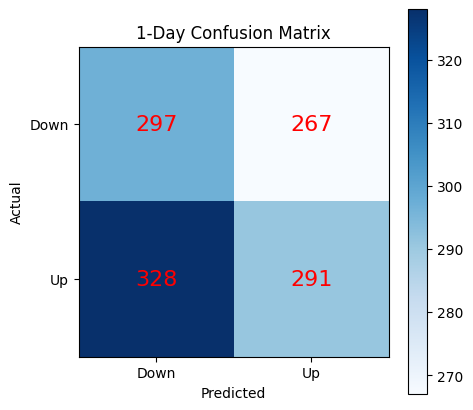


[1-Day] Per-stock Test Accuracy:
NFLX  : 46.89%
AAPL  : 51.44%
AMZN  : 47.58%
GOOGL : 51.29%
META  : 51.60%


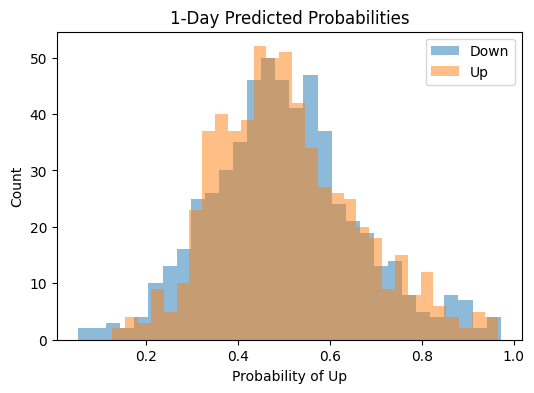


========== Training 30-Day Model ==========

[30-Day] Epoch 1, Loss: 0.6832
[30-Day] Epoch 2, Loss: 0.6683
[30-Day] Epoch 3, Loss: 0.6425
[30-Day] Epoch 4, Loss: 0.6072
[30-Day] Epoch 5, Loss: 0.5565
[30-Day] Epoch 6, Loss: 0.5216
[30-Day] Epoch 7, Loss: 0.4846
[30-Day] Epoch 8, Loss: 0.4541
[30-Day] Epoch 9, Loss: 0.4177
[30-Day] Epoch 10, Loss: 0.3862
[30-Day] Epoch 11, Loss: 0.3357
[30-Day] Epoch 12, Loss: 0.3166
[30-Day] Epoch 13, Loss: 0.2995
[30-Day] Epoch 14, Loss: 0.2777
[30-Day] Epoch 15, Loss: 0.2774
[30-Day] Epoch 16, Loss: 0.2655
[30-Day] Epoch 17, Loss: 0.2521
[30-Day] Epoch 18, Loss: 0.2365
[30-Day] Epoch 19, Loss: 0.2388
[30-Day] Epoch 20, Loss: 0.2273
[30-Day] Epoch 21, Loss: 0.2038
[30-Day] Epoch 22, Loss: 0.1931
[30-Day] Epoch 23, Loss: 0.1890
[30-Day] Epoch 24, Loss: 0.1781
[30-Day] Epoch 25, Loss: 0.1779
[30-Day] Epoch 26, Loss: 0.1735
[30-Day] Epoch 27, Loss: 0.1703
[30-Day] Epoch 28, Loss: 0.1661
[30-Day] Epoch 29, Loss: 0.1667
[30-Day] Epoch 30, Loss: 0.1646

[3

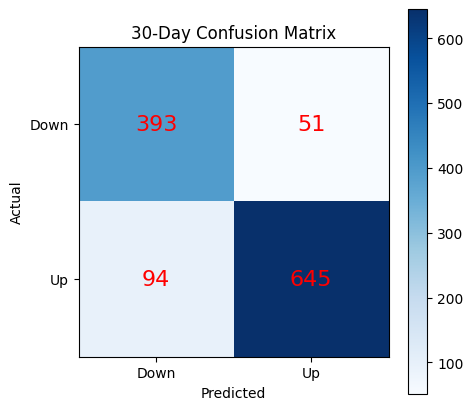


[30-Day] Per-stock Test Accuracy:
NFLX  : 84.02%
AAPL  : 85.95%
AMZN  : 90.00%
GOOGL : 88.43%
META  : 90.00%


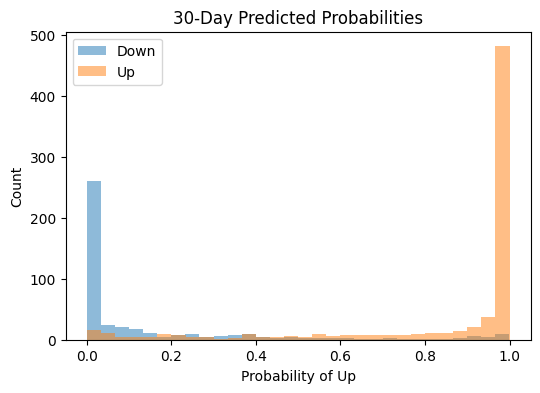

In [10]:
X1, y1, ids1 = build_sequences(df, features, targets["1-Day"], seq_len)
X30, y30, ids30 = build_sequences(df, features, targets["30-Day"], seq_len)

model_1d = train_and_evaluate(X1, y1, ids1, target_name="1-Day")
model_30d = train_and_evaluate(X30, y30, ids30, target_name="30-Day")